# 7주차 실습 2 : 위성이미지 변화 탐지
 실습은 서로 다른 두 시점의 위성 이미지를 비교하여 변화가 생긴 부분을 탐지하는 ResNet 기반 딥러닝 모델을 구축합니다. 큰 이미지를 작은 패치로 나누어 효율적으로 학습하고 PyTorch를 사용하여 구현합니다.
 
 미리 학습된 ResNet모델을 약간 변형하여 적용한다.

# 1. 라이브러리 설치
먼저 모델을 쉽게 구축할 수 있도록 사전 학습된 모델과 다양한 아키텍처를 제공하는 segmentation-models-pytorch 라이브러리를 설치합니다.

In [2]:
# 모델을 빌드하는 데 사용할 segmentation-models-pytorch 라이브러리 설치
!pip install segmentation-models-pytorch -q

# 2. 모듈 임포트
프로젝트에 필요한 라이브러리들을 모두 임포트합니다. PyTorch와 segmentation_models_pytorch가 핵심 라이브러리이며, 데이터 처리와 시각화를 위해 numpy, pandas, PIL, matplotlib 등을 사용합니다.

In [3]:
# 이 섹션에서 모든 모듈을 임포트합니다

import numpy as np # 선형대수
import pandas as pd # 데이터 처리, CSV 파일 입출력 (예: pd.read_csv)
import os
import glob
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
from random import shuffle
import scipy.misc
from PIL import Image
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import cv2
import os
import glob

# 3. 데이터 준비
3.1. 데이터셋 경로 설정
변화 탐지에 사용될 데이터는 여러 도시의 위성 이미지로 구성되어 있습니다. 각 도시마다 두 시점의 이미지(img1, img2)와 변화가 발생한 부분을 표시한 정답 이미지(label 또는 change mask)가 쌍으로 존재합니다.

In [4]:
# 데이터셋에 이미지가 있는 14개 도시 목록

cities = ['paris',
 'rennes',
 'bercy',
 'abudhabi',
 'hongkong',
 'aguasclaras',
 'saclay_e',
 'beirut',
 'mumbai',
 'pisa',
 'beihai',
 'bordeaux',
 'cupertino',
 'nantes']

In [5]:
len(cities) # 리스트 길이 확인

14

각 이미지 쌍과 정답 마스크의 전체 파일 경로를 리스트로 만듭니다.

In [6]:
# 이미지를 읽어올 입력 경로 지정
input_path = "../input/onera-satellite-change-detection-dataset/images/Onera Satellite Change Detection dataset - Images/"

img1 = []   # 첫 번째 이미지 세트의 경로 목록 생성
img2 = []   # 두 번째 이미지 세트의 경로 목록 생성
label = []  # 변화 탐지 마스크 이미지의 경로 목록 생성

for city in cities:
    img1.append(input_path + city + "/pair/" + "img1.png")
    img2.append(input_path + city + "/pair/" + "img2.png")
    label.append(f"../input/onera-satellite-change-detection-dataset/train_labels/Onera Satellite Change Detection dataset - Train Labels/{city}/cm/cm.png")


# 3.2. 샘플 데이터 시각화
데이터가 어떻게 구성되어 있는지 확인하기 위해 무작위로 샘플 하나를 선택하여 시각화해 보겠습니다. 왼쪽부터 순서대로 이미지 1(이전 시점), 이미지 2(이후 시점), 그리고 두 이미지 간의 **변화 영역(Change Mask)**입니다. 우리 모델은 이미지 1과 2를 입력받아 이 변화 영역을 예측하도록 학습될 것입니다.

(408, 390, 2)


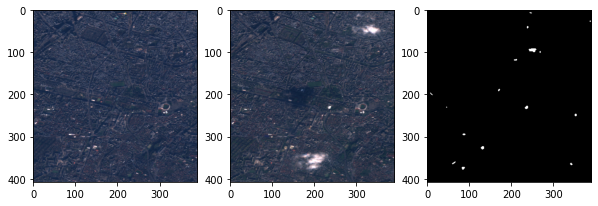

In [7]:
# 무작위 샘플 읽기 - 두 개의 이미지 세트와 관련된 변화 탐지 마스크

from PIL import Image
import matplotlib.pyplot as plt

sample = np.random.randint(0,13) # 0에서 13 사이의 무작위 숫자 생성    

im1 = Image.open(img1[sample])
im2 = Image.open(img2[sample])
lab = Image.open(label[sample]).convert('LA')
print(np.array(lab).shape)
fig,ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow(im1)
ax[1].imshow(im2)
ax[2].imshow(lab)

# 3.3. 이미지 패치(Patch) 생성
원본 위성 이미지는 크기가 매우 크기 때문에 그대로 모델에 입력하면 메모리 문제를 일으킬 수 있습니다. 이를 해결하고 데이터의 양을 늘리기 위해(Data Augmentation 효과) 전체 이미지를 64x64 크기의 작은 조각, 즉 **패치(Patch)**로 나눕니다.

아래 코드는 각 이미지를 64x64 크기의 패치로 나누고, 각 패치의 경로와 위치 정보를 DataFrame으로 정리합니다.

In [8]:
# 아래 코드는 전체 이미지를 64x64 크기의 패치로 나누는 코드입니다 

path1 = []
path2 = []
target = []
start_row = []
end_row = []
start_col = []
end_col = []

for im1,im2,lab in zip(img1,img2,label):
    for row in [0,64,128,192,256,320,384,448]:
        for col in [0,64,128,192,256,320,384,448]:
            row_start = row
            row_end = row + 64
            col_start = col
            col_end = col + 64
            
            path1.append(im1)
            path2.append(im2)
            target.append(lab)
            
            start_row.append(row_start)
            end_row.append(row_end)
            
            start_col.append(col_start)
            end_col.append(col_end)
            
df = pd.DataFrame({"path1":path1,"path2":path2,"target":target,"start_row":start_row,"end_row":end_row,"start_col":start_col,"end_col":end_col})
df

,path1,path2,target,start_row,end_row,start_col,end_col
0,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,0,64,0,64
1,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,0,64,64,128
2,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,0,64,128,192
3,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,0,64,192,256
4,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,0,64,256,320
...,...,...,...,...,...,...,...
891,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,448,512,192,256
892,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,448,512,256,320
893,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,448,512,320,384
894,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,../input/onera-satellite-change-detection-data...,448,512,384,448


# 4. 데이터셋 및 데이터로더 구성
4.1. PyTorch 커스텀 데이터셋 클래스
PyTorch에서 모델을 효율적으로 학습시키기 위해 Dataset 클래스를 정의합니다. 이 클래스는 모델에 데이터를 공급하는 역할을 하며, __getitem__ 메소드에서 앞에서 만든 DataFrame의 정보를 이용해 원본 이미지를 읽고, 정해진 위치의 64x64 패치를 잘라낸 후 텐서(Tensor) 형태로 변환하여 반환합니다.

In [9]:
# 모델 학습을 위한 이미지와 레이블을 생성하는 데 사용될 Python 데이터셋 클래스

class ChangeDataset():
    def __init__(self,df):
        self.df = df
        
    def __len__(self):
        return (len(self.df))
    
    def __getitem__(self,item):
        im1 = Image.open(self.df.loc[item,"path1"])
        im1 = np.array(im1.resize((512,512))) / 255 # 이미지를 512x512 크기로 조정
        im2 = Image.open(self.df.loc[item,"path2"])
        im2 = np.array(im2.resize((512,512))) / 255 # 이미지를 512x512 크기로 조정
        target = Image.open(self.df.loc[item,"target"]).convert("RGB")
        target = np.array(target.resize((512,512))) # 마스크를 512x512 크기로 조정
        target = (np.mean(target,axis=-1) > 0.5).astype(np.uint8)
        start_row = self.df.loc[item,"start_row"]
        end_row = self.df.loc[item,"end_row"]
        start_col = self.df.loc[item,"start_col"]
        end_col = self.df.loc[item,"end_col"]
        
        # 기본 이미지1에서 64x64 크기의 패치를 읽어옵니다
        im1 = torch.tensor(im1[start_row:end_row,start_col:end_col,:].transpose(2,1,0),dtype=torch.float)
          # 기본 이미지2에서 64x64 크기의 패치를 읽어옵니다
        im2 = torch.tensor(im2[start_row:end_row,start_col:end_col,:].transpose(2,1,0),dtype=torch.float)
          # 기본 변화 탐지 마스크에서 64x64 크기의 패치를 읽어옵니다
        target = torch.tensor(target[start_row:end_row,start_col:end_col],dtype=torch.long)
        
        return (im1,im2,target)

패치로 나눈 데이터를 훈련(train) 데이터셋과 검증(validation) 데이터셋으로 분리합니다.

In [10]:
train_ds = ChangeDataset(df[:700])  # 훈련 데이터셋
val_ds = ChangeDataset(df[700:].reset_index(drop=True)) # 검증 데이터셋

sample = np.random.randint(0,100) # 0에서 100 사이의 무작위 숫자 생성

im1,im2,target = train_ds[sample] # 훈련 데이터셋에서 무작위 샘플 읽기
im1.shape,im2.shape,target.shape  # shape 확인

(torch.Size([3, 64, 64]), torch.Size([3, 64, 64]), torch.Size([64, 64]))

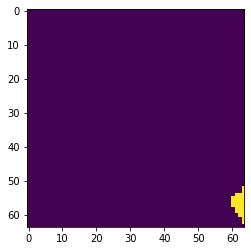

In [11]:
plt.imshow(target.numpy())  # 변화 탐지 마스크 출력

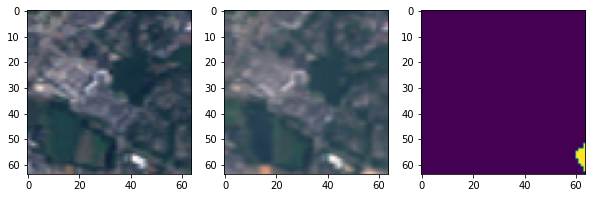

In [12]:
# 이미지1, 이미지2 그리고 변화 탐지 마스크 출력

fig,ax = plt.subplots(1,3,figsize=(10,10))
ax[0].imshow(im1.numpy().transpose(1,2,0))
ax[1].imshow(im2.numpy().transpose(1,2,0))
ax[2].imshow(target.numpy())

# 4.2. 데이터로더 생성
Dataset을 DataLoader로 감싸주면, 학습 시 배치(batch) 단위로 데이터를 묶어주고 데이터를 섞는(shuffle) 등의 작업을 편리하게 처리할 수 있습니다.

In [13]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds,batch_size=256, shuffle=True)  # 훈련 데이터셋을 훈련 데이터로더로 변환
val_dl = DataLoader(val_ds,batch_size=256, shuffle=False)  # 검증 데이터셋을 검증 데이터로더로 변환

# 5. 모델 아키텍처
5.1. 기본 모델: Resnet
변화 탐지는 이미지의 각 픽셀이 변했는지 아닌지를 분류하는 Semantic Segmentation 문제로 볼 수 있습니다. 이러한 문제에 효과적인 Resnet 아키텍처를 기본 모델로 사용합니다.

In [14]:
model = smp.Unet('resnet34', encoder_depth=3,decoder_channels=(64, 64, 16)) # build a base model based on Unet architecture with a resnet34 encoder 

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

# 5.2. ChangeNet 모델 정의
두 이미지의 변화를 탐지하기 위해, 두 이미지가 동일한 인코더를 공유하는 Siamese 네트워크 구조를 활용합니다.

두 개의 입력 이미지(x1, x2)를 각각 동일한 ResNet34 인코더에 통과시켜 잠재 특징(latent feature)을 추출합니다.

각각의 이미지에서 나온 잠재 특징들을 서로 더하여 두 이미지의 관계를 나타내는 새로운 특징을 만듭니다.

이 통합된 특징을 U-Net의 **디코더(Decoder)**에 통과시켜 원본 이미지 크기로 복원합니다.

마지막으로 **분할 헤드(Segmentation Head)**를 거쳐 각 픽셀이 변했는지(1) 변하지 않았는지(0)를 나타내는 최종 변화 탐지 마스크를 생성합니다.

In [15]:
# ChangeNet 모델

class ChangeNet(nn.Module):
    def __init__(self,model):
        super().__init__()
        self.encoder = model.encoder  #모델 인코더
        self.decoder = model.decoder  #모델 디코더
        self.head = model.segmentation_head  #변화 탐지 마스크 생성을 위한 분할 헤드
        
    def forward(self,x1,x2):
        enc1 = self.encoder(x1)  # 이미지1의 잠재 특징(latent feature) 추출
        enc2 = self.encoder(x2)  # 이미지2의 잠재 특징(latent feature) 추출
        encoder_out = []
        for i in range(len(enc1)):
            encoder_out.append(torch.add(enc1[i],enc2[i])) # 두 잠재 특징을 더한 후 리스트에 추가
        decoder_out = self.decoder(*encoder_out) # 잠재 특징을 디코더에 통과
        out = self.head(decoder_out) # 디코더 결과물을 분할 헤드에 통과시켜 변화 탐지 마스크 생성
        return out

# 6. 모델 학습
6.1. 학습 환경 설정
GPU가 있다면 더 빠른 학습을 위해 GPU를 사용하도록 설정합니다.

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')  #GPU가 사용 가능하면 GPU에서 훈련

In [17]:
change_model = ChangeNet(model).to(device) #모델을 해당 장치(device)로 이전

# 6.2. 학습 루프
이제 모델을 학습시킬 준비가 되었습니다.

손실 함수(Loss Function): 각 픽셀을 이진 분류(변함/변하지 않음)하는 문제이므로 BCEWithLogitsLoss를 사용합니다.

옵티마이저(Optimizer): 파라미터를 효율적으로 업데이트하기 위해 Adam 옵티마이저를 사용합니다.

학습 과정: 총 5 에포크(Epoch) 동안 훈련 데이터를 반복 학습합니다. 각 단계마다 모델은 예측을 생성하고, 정답과 비교하여 손실(loss)을 계산한 후, 역전파(backpropagation)를 통해 모델의 가중치를 업데이트합니다

In [19]:
from tqdm.notebook import tqdm

#이진 분류 문제이므로 손실 함수는 BCE 손실(BCE loss)을 사용
criterion = torch.nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(change_model.parameters(), lr=0.0001)

for epoch in tqdm(range(5)):  # 에포크(Epoch) 수 = 5
    
    epoch_loss = []
    # 데이터를 반복합니다.
        
    change_model.train() # 모델을 훈련 상태로 설정
    for x1,x2,target in tqdm(train_dl,total=len(train_dl)):
        x1 = x1.to(device)  #입력 데이터를 해당 장치(device)로 이전
        x2 = x2.to(device)  #입력 데이터를 해당 장치(device)로 이전
        target = target.to(device)  #입력 데이터를 해당 장치(device)로 이전
                
        # 파라미터 그래디언트를 0으로 만듭니다.
        optimizer.zero_grad()   #옵티마이저 초기화

        # 순전파(forward)
        outputs = change_model(x1,x2)  # 모델 예측 생성
        loss = criterion(outputs.squeeze(), target.float()) # 손실 평가

        # 훈련 단계에서만 역전파(backward) + 최적화(optimize)
        
        loss.backward()  # 그래디언트 계산
        optimizer.step()  # 옵티마이저를 사용하여 파라미터 재계산
        epoch_loss.append(loss.item())
    
    print(f"Epoch {epoch}, Loss:",np.array(epoch_loss).mean())

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0, Loss: 0.8061115344365438


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Loss: 0.767706553141276


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2, Loss: 0.7329219579696655


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3, Loss: 0.7011468410491943


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4, Loss: 0.671355406443278


# 7. 결과 확인 (추론)
학습된 모델을 사용하여 검증 데이터셋의 샘플에 대한 예측을 수행하고, 그 결과를 시각화하여 성능을 확인합니다.

model.eval(): 모델을 추론(예측) 모드로 변경합니다.

torch.sigmoid: 모델의 출력값(logit)을 0과 1 사이의 확률 값으로 변환합니다.

아래 결과에서 **실제 마스크(왼쪽 아래)**와 **예측된 마스크(오른쪽 아래)**를 비교하여 모델이 변화 영역을 얼마나 잘 탐지했는지 확인할 수 있습니다.

In [20]:
len(val_ds)

196

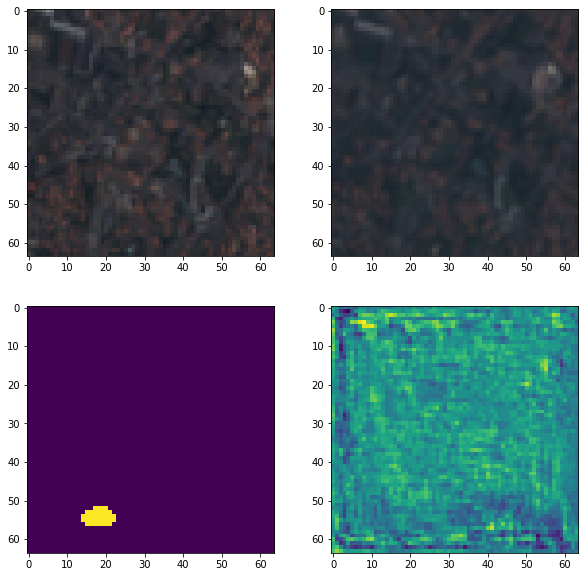

In [21]:
change_model.eval()  #예측 생성을 위해 모델을 평가 모드로 설정

s = 190 # 무작위 샘플

with torch.no_grad():
    #예측 생성 및 예측값을 torch.sigmoid 함수에 통과
    pred_mask = (torch.sigmoid(change_model(val_ds[s][0].unsqueeze(dim=0).to(device),val_ds[s][1].unsqueeze(dim=0).to(device))).squeeze()).detach().cpu().numpy()  


# 샘플 이미지1, 샘플 이미지2, 실제 변화 탐지 마스크(ground truth), 예측된 마스크 표시    
fig,ax = plt.subplots(2,2,figsize=(10,10))
ax[0][0].imshow(val_ds[s][0].numpy().transpose(1,2,0))
ax[0][1].imshow(val_ds[s][1].numpy().transpose(1,2,0))
ax[1][0].imshow(val_ds[s][2].numpy())
ax[1][1].imshow(pred_mask)